### Building a neural network with Pytorch on MNIST dataset


In this notebook we'll use 
- nn.Module is the Base class for all neural network modules.Our models should also subclass this class.
- optim utility packages provided within PyTorch. To do the Optimization
- We subclass nn.Module (which itself is a class and able to keep track of state). 
- nn.Module has a number of attributes and methods (such as .parameters() and .zero_grad()) which we will be using to perform different operations required.

In this tutorial ,  we will create a Deep Learning model for building a handwritten digit classifier. We will make use of the MNIST dataset included in the torchvision package.
 
<b>Data Preprocessing</b>:

 Mandatory first step is to do the basic data pre-processing steps , using the a utility called <b>transforms</b> which comes from torchvision package.
 
 We will do two below mentioned basic data preprocessing operations (this will be explained more detail in case of CNN tutorial).
 
- Transform the raw dataset into tensors.
- Normalize the dataset.

We will also import the dataset from torch vision package.

In [11]:
import torch
from torchvision.datasets import MNIST

In [12]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # The values 0.1307 and 0.3081 used for the Normalize() transformation are the global mean and standard deviation of the MNIST dataset.
    ])

In [13]:
# choose the training
train_data = MNIST(root='data', train=True,
                                   download=True, transform=transform)

In [14]:
#size of train data
len(train_data)

60000

In [15]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 50

Data Loader helps us to create batches of data , we will go deeper into DataLoader in next tutorial

In [16]:
import numpy as np
from torch.utils.data import DataLoader

# data loader preparation
train_loader = DataLoader(train_data, batch_size=batch_size,num_workers=num_workers)

In [17]:
# Let's check the shape of the input/target data
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([50, 1, 28, 28])
torch.Size([50])


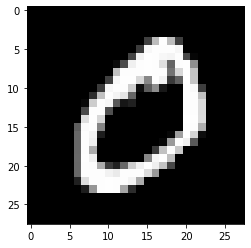

In [18]:
# Checking an sample image , data
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

In [19]:
# storing it for prediction , once the model is trained
img_zero = images[1]

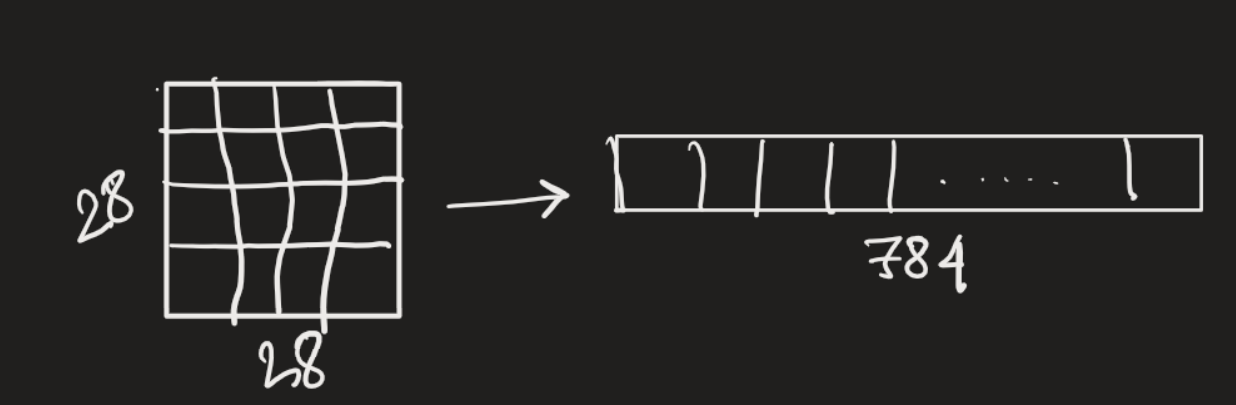

As we can see that input data is not flattened to pass through the linear layers. Network can only accept a vector. 

So we will need to reshape the batch in a format of (batch size , no of features).

number of features -> 1 * 28 * 28 = 784

Shape of target data is as expected.

### Architecture

We create a new class (which inherits the properties from the base class from nn package called Module) to define the archietecture of the Neural Network. 

- Layer defination should be inside the constructor of the class.
- Forward propagation step should be included inside forward method.

Activations(Relu,Sigmoid,Tanh etc) and loss functions(cross entropy,nllloss etc) comes from torch.nn.functional module. This module contains all the functions in the torch.nn module.

Syntax of nn.Linear() is (input size, output size)

This NN architecture below represents the 784 nodes (28*28 pixels) in the input layer, 256 in the hidden layer, and 10 in the output layer(0-9 numbers). Inside the forward function, we will use the relu activation function in the hidden layer which present under torch.nn.functional module.

In [20]:
from torch import nn, optim
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x):
        # input tensor is flattened 
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

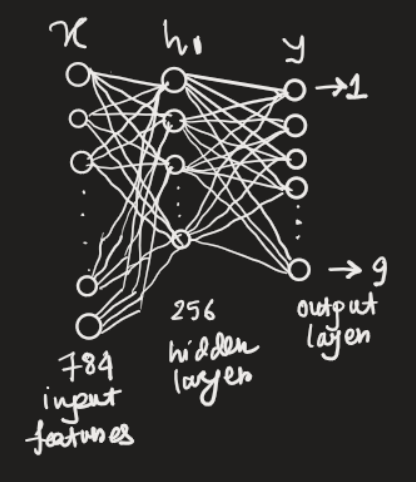

In [21]:
model = Model()

In [ ]:
criterion = nn.CrossEntropyLoss()

from torch import optim

optimizer = optim.SGD(model.parameters(), lr=0.01)

Now we will define the loss and optimizer functions

- <b>Loss Function</b> : Here we have used the CrossEntropyLoss() function.Generally loss assigned to `criterion`. for MNIST classification , we generally use softmax function to predict class probabilities. With a softmax output, you want to use cross-entropy as the loss.

Few things to keep in mind while using the CrossEntropyLoss() in Pytorch 

    - CrossEntropyLoss criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
    - The input is expected to contain scores for each class.

This means we need to pass in the raw output of our network into the loss, not the output of the softmax function.That's why there is no activation after self.fc2(x).

Here is a great article to understand Pytorch's Loss functions from scratch - https://medium.com/@zhang_yang/pytorch-loss-funtions-in-plain-python-b79c05f8b53f

- <b>Optimizer</b> : Pytorch also has a package with various optimization algorithms, torch.optim. We can use the step method from our optimizer to take a weight update step, instead of manually updating each parameter.Below are the few availavle optimizer in pytorch -

    - optim.Adam
    - optim.RMSprop
    - optim.SGD
    - optim.Adagrad

Learn more about optimizers from My Deep learning with Pytorch Series - https://youtu.be/atacYUlofcs?si=VFFaGnraWoKfP5Wo

In the optimizer we need to pass model parameters(can be accesed using model.parameters()) for the back propagation operation.

<b>Traning the Model:<b>

In [23]:
for epoch in range(1, 11): ## run the model for 10 epochs
    train_loss = []
    
    ## training part 
    
    for data, target in train_loader:
        optimizer.zero_grad()
        ## 1. forward propagation
        output = model(data)
        
        ## 2. loss calculation
        loss = criterion(output, target)
        
        ## 3. backward propagation
        loss.backward()
        
        ## 4. weight optimization
        optimizer.step()
        
        train_loss.append(loss.item())
        
    print ("Epoch:", epoch, "Training Loss: ", np.mean(train_loss))

Epoch: 1 Training Loss:  0.5173912334442139
Epoch: 2 Training Loss:  0.2723297640448436
Epoch: 3 Training Loss:  0.2232327368343249
Epoch: 4 Training Loss:  0.18981850059004501
Epoch: 5 Training Loss:  0.16513597692285353
Epoch: 6 Training Loss:  0.1461139890392466
Epoch: 7 Training Loss:  0.130946430528226
Epoch: 8 Training Loss:  0.11848786374010767
Epoch: 9 Training Loss:  0.10810955879744143
Epoch: 10 Training Loss:  0.0993347416104128


Few Steps to note:

- <b>optimizer.zero_grad()</b>: - will zero out the gradients from previous traning step , in this way gradients won't be   accumulated. This should be done before calculating the gradients at each batch.
- <b>criterion(output, target)</b>: - we feed in the model predicted values along with actual values to calculate the loss.
- <b>optimizer.step()</b>: Once we call loss.backward() , gradients will be calculated and we will use this gradients to update the weights in this step using the learning rate defined in optim.SGD(model.parameters(), lr=0.01).

## Creating the model with F.log_softmax + nn.NLLLoss()

In [24]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [25]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [26]:
for epoch in range(1, 6): ## run the model for 5 epochs
    train_loss = []
    
    ## training part 
    
    for data, target in train_loader:
        optimizer.zero_grad()
        ## 1. forward propagation
        output = model(data)
        
        ## 2. loss calculation
        loss = criterion(output, target)
        
        ## 3. backward propagation
        loss.backward()
        
        ## 4. weight optimization
        optimizer.step()
        
        train_loss.append(loss.item())
        
    print ("Epoch:", epoch, "Training Loss: ", np.mean(train_loss))

Epoch: 1 Training Loss:  0.2523859895950106
Epoch: 2 Training Loss:  0.12908158224226401
Epoch: 3 Training Loss:  0.10012071989716788
Epoch: 4 Training Loss:  0.08193924614078545
Epoch: 5 Training Loss:  0.0737489186593181


#### Now how to do Prediction?

In [27]:
# Calculate the class probabilities (softmax) for img
log_ps = model(img_zero)
ps = torch.exp(log_ps)

In [28]:
print(ps)
print(ps.shape)

tensor([[9.9999e-01, 5.5890e-10, 9.6160e-06, 3.2103e-09, 1.2016e-09, 5.5477e-08,
         4.5719e-08, 2.0092e-09, 4.6463e-08, 7.2084e-07]],
       grad_fn=<ExpBackward0>)
torch.Size([1, 10])


- With the probabilities, we can get the most likely class using the ps.topk method. 
- This returns the  𝑘  highest values. 

- Since we just want the most likely class, we can use ps.topk(1). 

- This returns a tuple of the top- k  values and the top- 𝑘  indices. If the highest value is the 0'th element, we'll get back 0 as the index

In [29]:
top_p, top_class = ps.topk(1, dim=1)

In [30]:
top_p 

tensor([[1.0000]], grad_fn=<TopkBackward0>)

In [31]:
top_class

tensor([[0]])

#### Checking accuracy on the first batch

In [32]:
len(images)

50

In [33]:
log_ps = model(images)
ps = torch.exp(log_ps)

In [34]:
top_p, top_class = ps.topk(1, dim=1)

In [35]:
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[5],
        [0],
        [4],
        [1],
        [9],
        [2],
        [1],
        [3],
        [1],
        [4]])


In [36]:
top_class.shape , labels.shape

(torch.Size([50, 1]), torch.Size([50]))

Now we can check if the predicted classes match the labels. This is simple to do by equating top_class and labels, but we have to be careful of the shapes. Here top_class is a 2D tensor with shape (50, 1) while labels is 1D with shape (50). To get the equality to work out the way we want, top_class and labels must have the same shape.

In [37]:
equals = top_class == labels.view(*top_class.shape)

In [38]:
equals

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

In [39]:
accuracy = torch.mean(equals)
print(f'Accuracy: {accuracy.item()*100}%')

RuntimeError: mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Bool

This happens because equals has type torch.ByteTensor but torch.mean isn't implement for tensors with that type. So we'll need to convert equals to a float tensor. Note that when we take torch.mean it returns a scalar tensor, to get the actual value as a float we'll need to do accuracy.item()

In [ ]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 93.99999976158142%
